To install helix, run `pip install -e /path/to/helix/repo` 

In [1]:
import numpy as np
import strax as sx
import numba
import pandas as pd
import scipy as sp
import os

import shutil
from glob import glob
from matplotlib import pyplot as plt

# Extract the active environment name from the CONDA_PREFIX environment variable
conda_env = os.environ.get('CONDA_DEFAULT_ENV', None)
print(f"Active Conda Environment: {conda_env}")


print("strax version:", sx.__version__)
print("NumPy version:", np.__version__)
print("Numba version:", numba.__version__)
print("Pandas version:", pd.__version__)
print("SciPy version:", sp.__version__)
!python --version


Active Conda Environment: hupdate
strax version: 2.0.4
NumPy version: 1.26.4
Numba version: 0.60.0
Pandas version: 2.2.3
SciPy version: 1.15.1
Python 3.12.8


In [2]:
import helix as hx
print("helix version:", hx.__version__)


helix version: 0.0.0


In [3]:
run_id = 'run10' 
duration = 30  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel

Loading events: |                    | 0.00 % [00:08<?], #6 (1.84 s). 198.1 MB/s


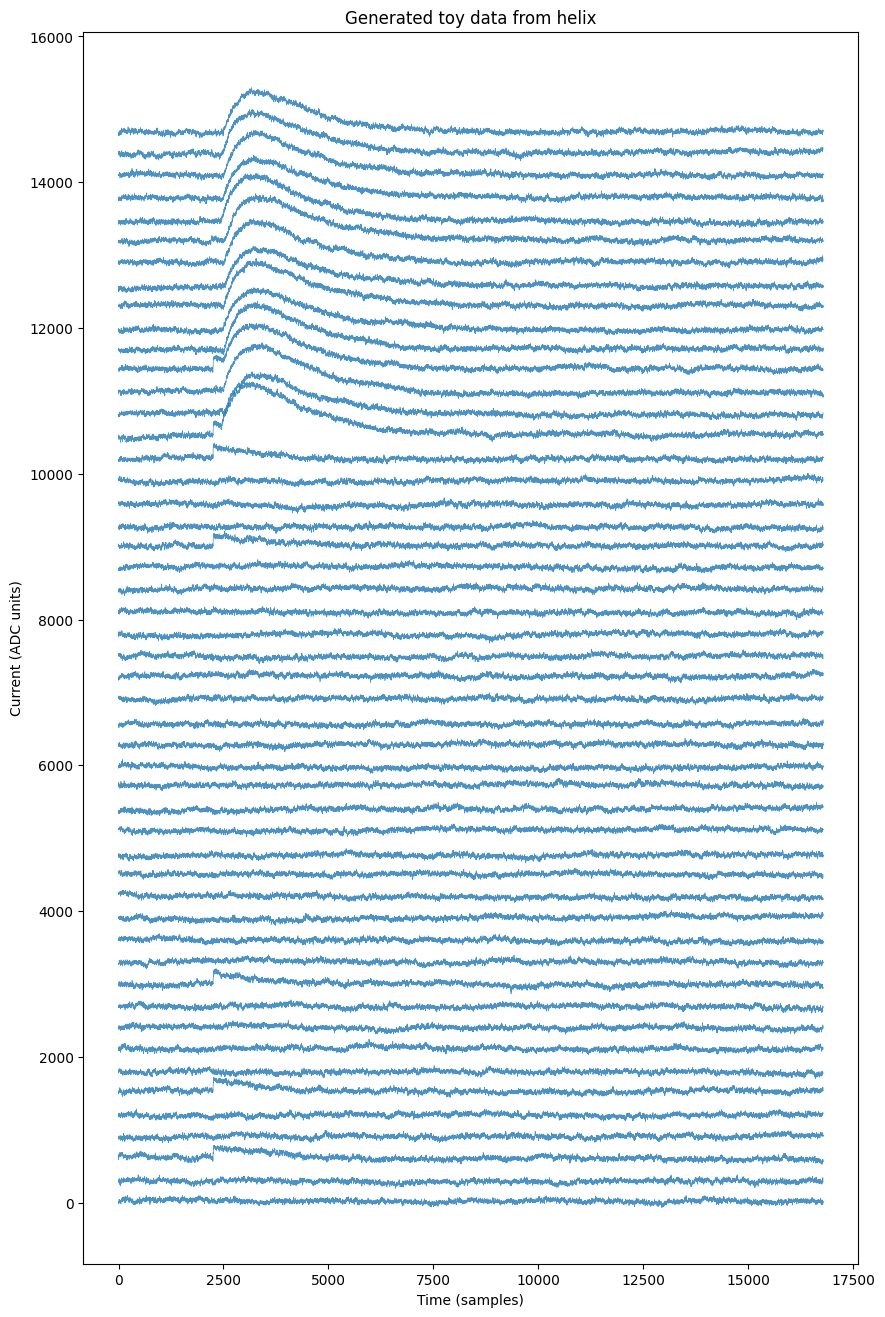

In [4]:
# creating context, registering storage and plugins
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.ToyDataRawRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 1}                 # for the hx.NoiseEvents plugin

# passing the settings to the plugins. Strax finds which plugins take these options automatically
context.set_config(config)
events = context.get_array(run_id, 'events')
# Load the raw data directly from the events or traces
raw_data = events['channel_data']

# Choose the event to plot
event_index = 100  # Change this index to select a different event

# Generate artificial baselines to separate channels visually
artificial_baselines = np.arange(len(raw_data[event_index])) * 300

# Plot the raw data
plt.figure(figsize=(10, 16))
plt.plot(raw_data[event_index].T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')
plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.title(f'Generated toy data from helix')
#plt.savefig('raw_data_traces_plot.png', dpi=300, bbox_inches='tight')

plt.show()


In [10]:
class Events(sx.Plugin):
    depends_on = ()

    def process_traces(self, traces):
        return {'channel_data': traces.values}

# Load traces.csv
traces_path = "traces.csv"  # Update path if needed
traces = pd.read_csv(traces_path)

# Initialize the Events plugin and process traces
events_plugin = Events()
events = events_plugin.process_traces(traces)

raw_data = events['channel_data']  # This is already a NumPy array
num_traces = traces.shape[0]
samples_per_trace = traces.shape[1]

trace_info = {
    "Number of Traces": num_traces,
    "Samples per Trace": samples_per_trace
}

trace_info


{'Number of Traces': 99, 'Samples per Trace': 32768}

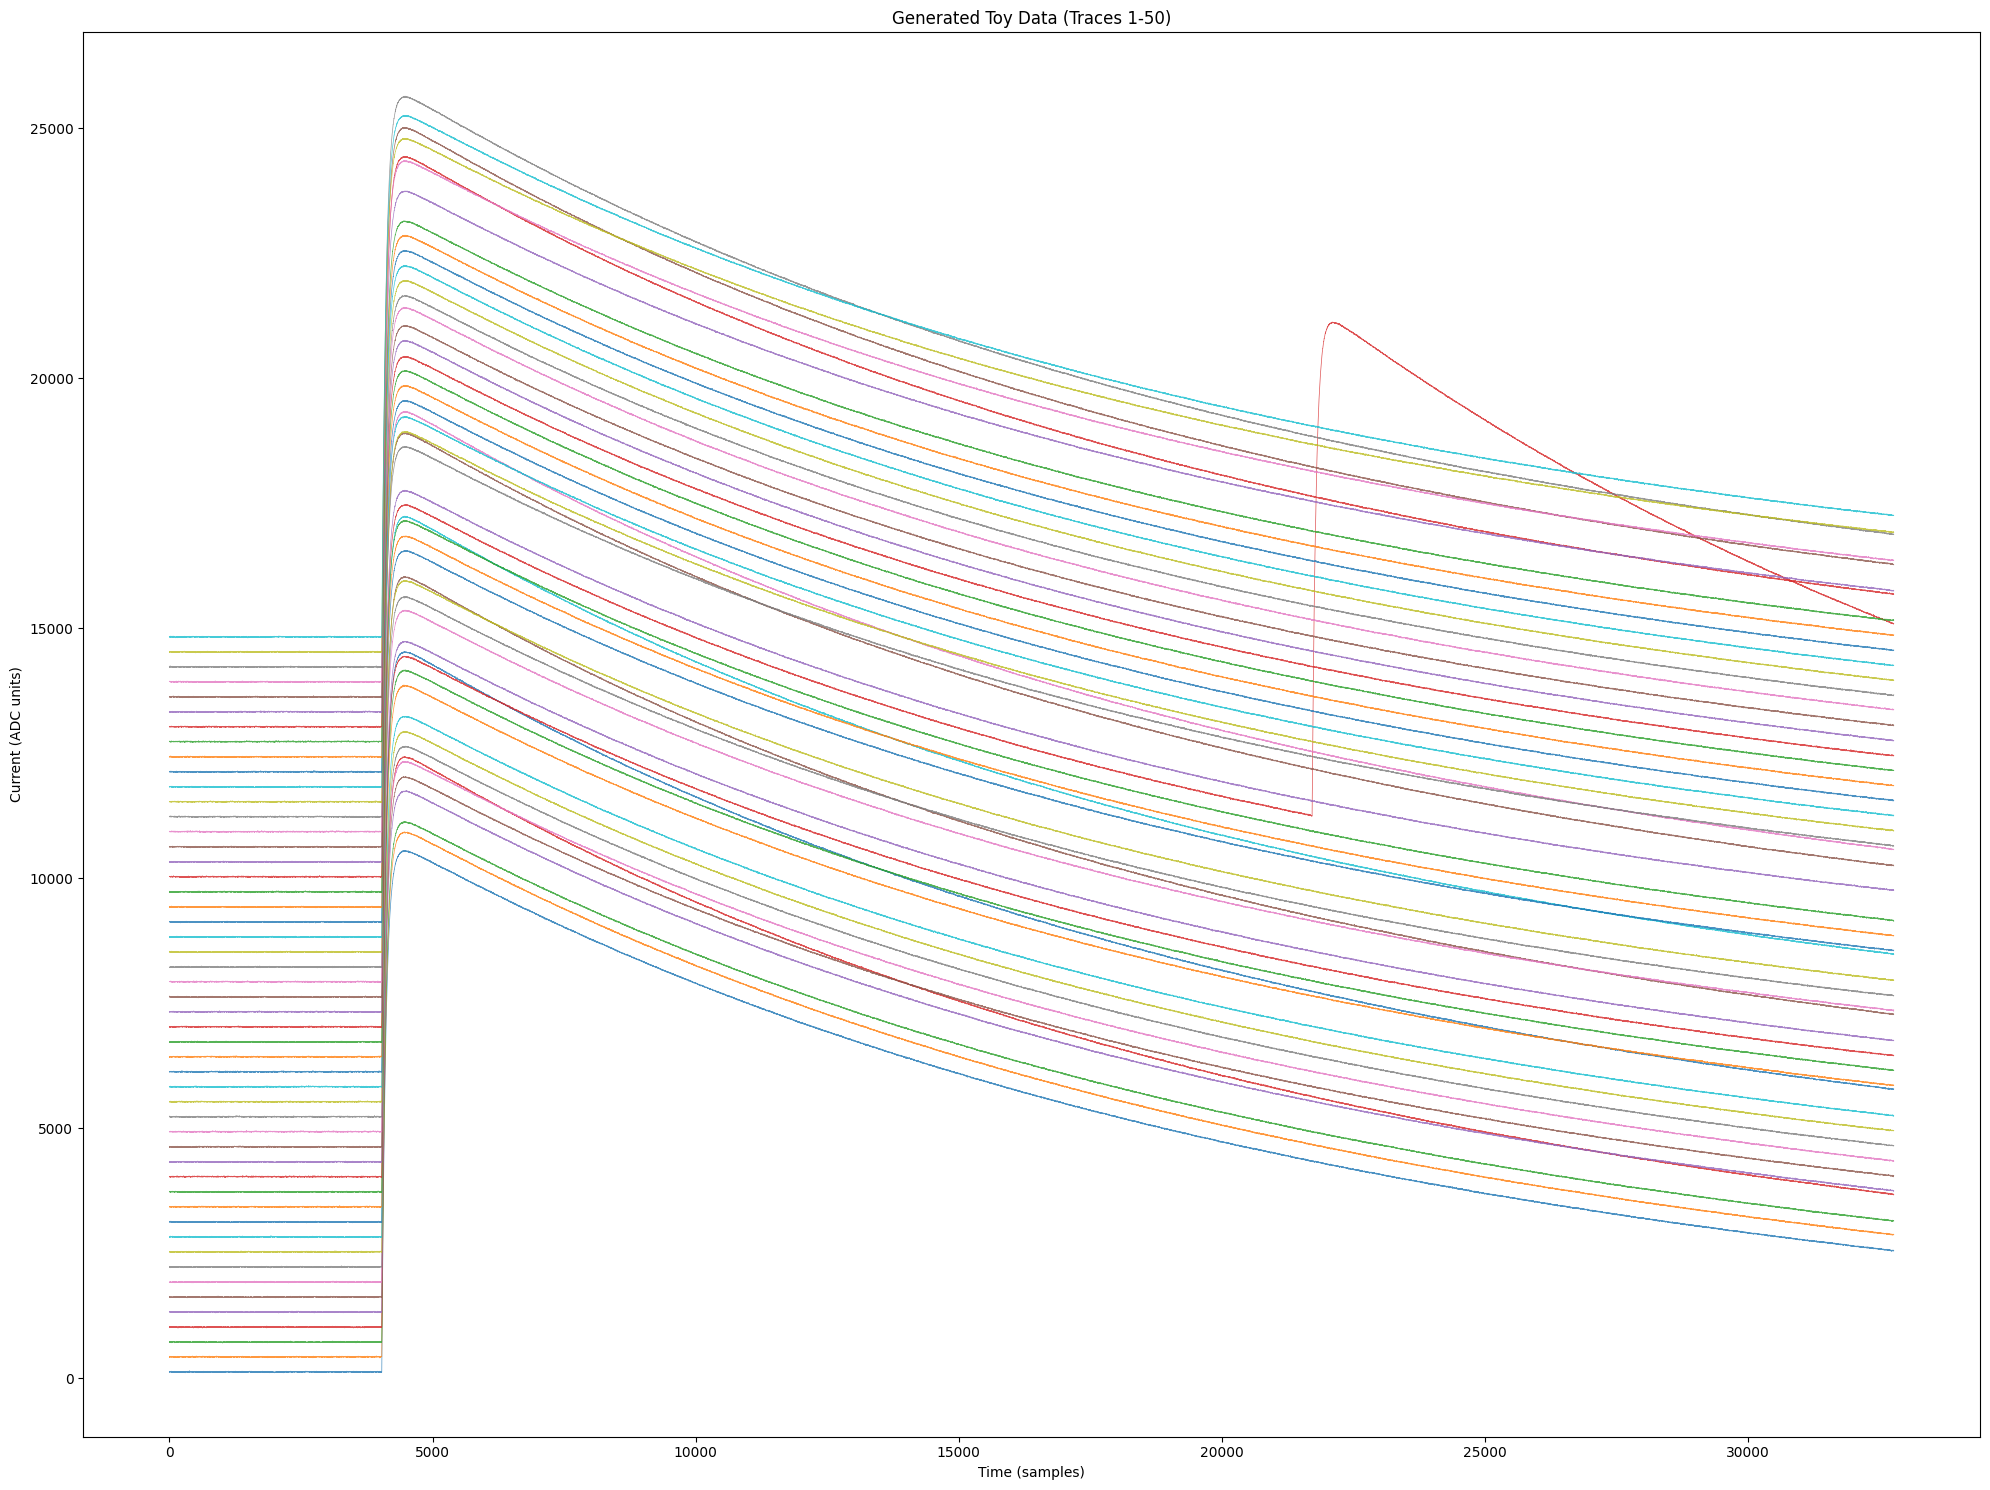

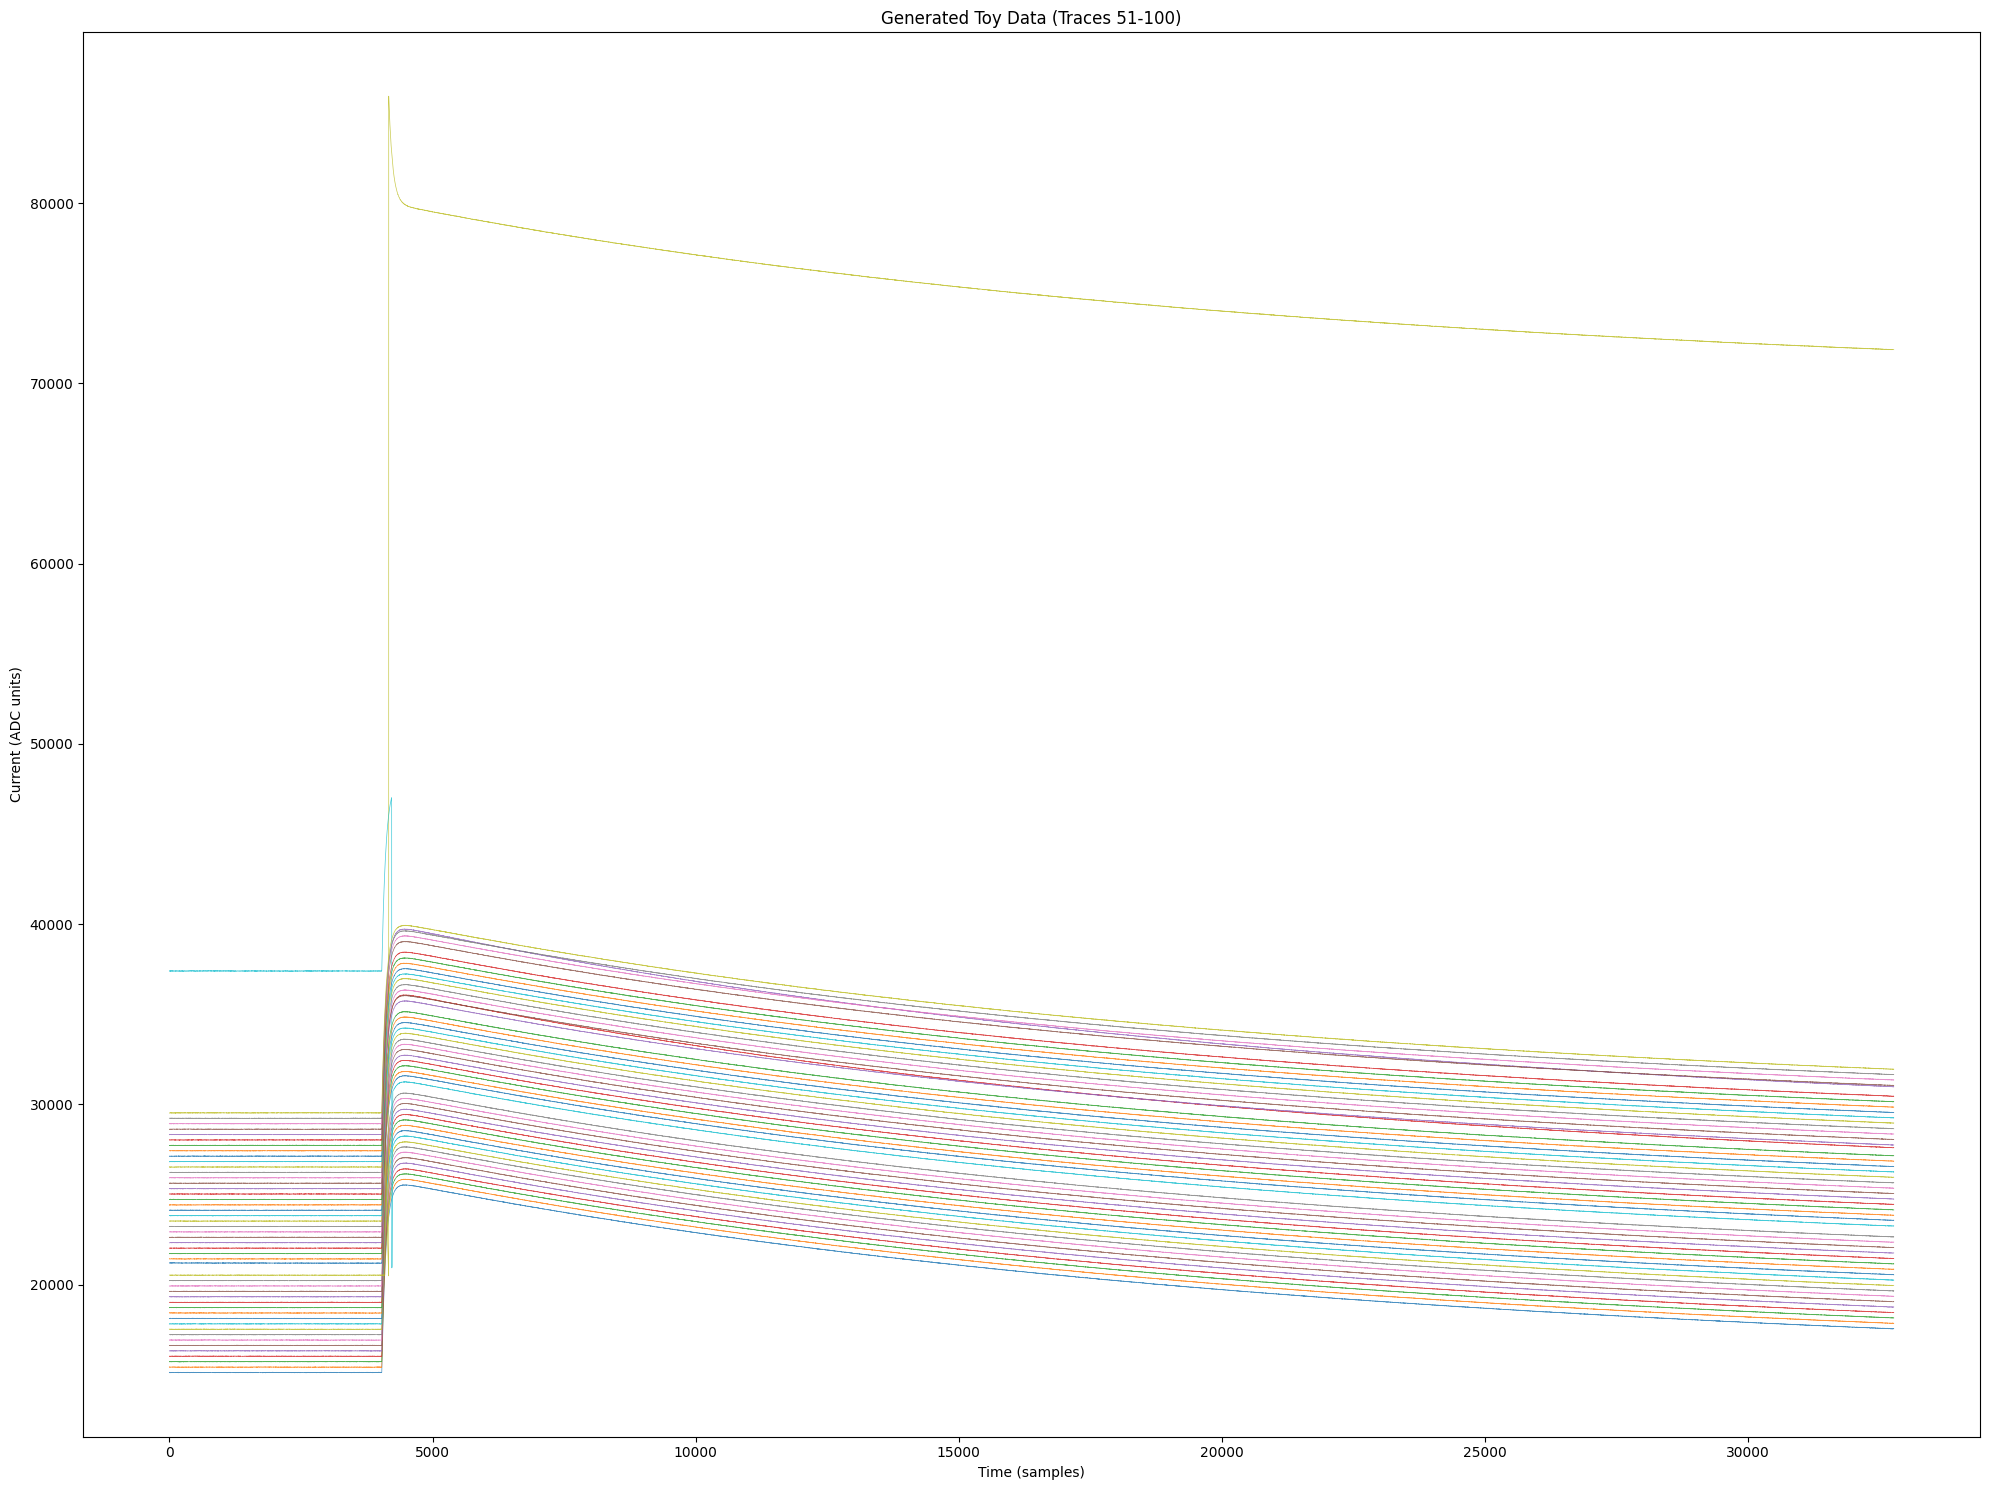

In [17]:
num_traces = min(100, len(raw_data))  # Limit to 100 or total available traces
traces_per_plot = 50  # Number of traces per plot

# Generate artificial baselines for better visualization
artificial_baselines = np.arange(num_traces) * 300  # Separate each trace by 300 units

# Prepare the data for plotting
traces_to_plot = raw_data[:num_traces].T  # Transpose to make time the x-axis (32768 × num_traces)

# Function to plot traces
def show_traces(traces, baselines, start_idx, end_idx, plot_title):
    plt.figure(figsize=(20, 15))
    for i, trace in enumerate(traces[:, start_idx:end_idx].T):  # Select the traces for this plot
        plt.plot(trace + baselines[start_idx + i], lw=0.5, alpha=0.8)  # Add offset for each trace
    plt.xlabel('Time (samples)')
    plt.ylabel('Current (ADC units)')
    plt.title(plot_title)
    plt.tight_layout()
    plt.show()  # Show the plot

# Show the first 50 traces
show_traces(traces_to_plot, artificial_baselines, 0, traces_per_plot, 'Data from exercise (Traces 1-50)')

# Show the next 50 traces
show_traces(traces_to_plot, artificial_baselines, traces_per_plot, num_traces, 'Data from exercise (Traces 51-100)')
